In [3]:
import collections
collections.Iterable = collections.abc.Iterable

In [4]:
!pip install --quiet phiflow==1.5.1
import math
from phi.tf.flow import *
import numpy as np
rnd = math.choose_backend(1)

In [5]:
def network(x, t):
    """ Dense neural network with 8 hidden layers and 3021 parameters in total.
        Parameters will only be allocated once (auto reuse).
    """
    y = math.stack([x, t], axis=-1)
    for i in range(8):
        y = tf.layers.dense(y, 20, activation=tf.math.tanh, name='layer%d' % i, reuse=tf.AUTO_REUSE)
    return tf.layers.dense(y, 1, activation=None, name='layer_out', reuse=tf.AUTO_REUSE)

def boundary_tx(N):
    x = np.linspace(-1,1,128)
    # precomputed solution from forward simulation:
    u = np.asarray( [0.008612174447657694, 0.02584669669548606, 0.043136357266407785, 0.060491074685516746, 0.07793926183951633, 0.0954779141740818, 0.11311894389663882, 0.1308497114054023, 0.14867023658641343, 0.1665634396808965, 0.18452263429574314, 0.20253084411376132, 0.22057828799835133, 0.23865132431365316, 0.25673879161339097, 0.27483167307082423, 0.2929182325574904, 0.3109944766354339, 0.3290477753208284, 0.34707880794585116, 0.36507311960102307, 0.38303584302507954, 0.40094962955534186, 0.4188235294008765, 0.4366357052408043, 0.45439856841363885, 0.4720845505219581, 0.4897081943759776, 0.5072391070000235, 0.5247011051514834, 0.542067187709797, 0.5593576751669057, 0.5765465453632126, 0.5936507311857876, 0.6106452944663003, 0.6275435911624945, 0.6443221318186165, 0.6609900633731869, 0.67752574922899, 0.6939334022562877, 0.7101938106059631, 0.7263049537163667, 0.7422506131457406, 0.7580207366534812, 0.7736033721649875, 0.7889776974379873, 0.8041371279965555, 0.8190465276590387, 0.8337064887158392, 0.8480617965162781, 0.8621229412131242, 0.8758057344502199, 0.8891341984763013, 0.9019806505391214, 0.9143881632159129, 0.9261597966464793, 0.9373647624856912, 0.9476871303793314, 0.9572273019669029, 0.9654367940878237, 0.9724097482283165, 0.9767381835635638, 0.9669484658390122, 0.659083299684951, -0.659083180712816, -0.9669485121167052, -0.9767382069792288, -0.9724097635533602, -0.9654367970450167, -0.9572273263645859, -0.9476871280825523, -0.9373647681120841, -0.9261598056102645, -0.9143881718456056, -0.9019807055316369, -0.8891341634240081, -0.8758057205293912, -0.8621229450911845, -0.8480618138204272, -0.833706571569058, -0.8190466131476127, -0.8041372124868691, -0.7889777195422356, -0.7736033858767385, -0.758020740007683, -0.7422507481169578, -0.7263049162371344, -0.7101938950789042, -0.6939334061553678, -0.677525822052029, -0.6609901538934517, -0.6443222327338847, -0.6275436932970322, -0.6106454472814152, -0.5936507836778451, -0.5765466491708988, -0.5593578078967361, -0.5420672759411125, -0.5247011730988912, -0.5072391580614087, -0.4897082914472909, -0.47208460952428394, -0.4543985995006753, -0.4366355580500639, -0.41882350871539187, -0.40094955631843376, -0.38303594105786365, -0.36507302109186685, -0.3470786936847069, -0.3290476440540586, -0.31099441589505206, -0.2929180880304103, -0.27483158663081614, -0.2567388003912687, -0.2386513127155433, -0.22057831776499126, -0.20253089403524566, -0.18452269630486776, -0.1665634500729787, -0.14867027528284874, -0.13084990929476334, -0.1131191325854089, -0.09547794429803691, -0.07793928430794522, -0.06049114408297565, -0.0431364527809777, -0.025846763281087953, -0.00861212501518312] );
    t = np.asarray(rnd.ones_like(x)) * 0.5
    perm = np.random.permutation(128) 
    return (x[perm])[0:N], (t[perm])[0:N], (u[perm])[0:N]

def _ALT_t0(N): # alternative, impose original initial state at t=0
    x = rnd.random_uniform([N], -1, 1)
    t = rnd.zeros_like(x)
    u = - math.sin(np.pi * x)
    return x, t, u

def open_boundary(N):
    t = rnd.random_uniform([N], 0, 1)
    x = math.concat([math.zeros([N//2]) + 1, math.zeros([N//2]) - 1], axis=0)
    u = math.zeros([N])
    return x, t, u

In [6]:
def f(u, x, t):
    """ Physics-based loss function with Burgers equation """
    u_t = gradients(u, t)
    u_x = gradients(u, x)
    u_xx = gradients(u_x, x)
    return u_t + u*u_x - (0.01 / np.pi) * u_xx

In [7]:
N=128
grids_xt = np.meshgrid(np.linspace(-1, 1, N), np.linspace(0, 1, 33), indexing='ij')
grid_x, grid_t = [tf.convert_to_tensor(t, tf.float32) for t in grids_xt]

# create 4D tensor with batch and channel dimensions in addition to space and time
# in this case gives shape=(1, N, 33, 1)
grid_u = math.expand_dims(network(grid_x, grid_t))

<ipython-input-5-f2ebc84042fb>:7: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  y = tf.layers.dense(y, 20, activation=tf.math.tanh, name='layer%d' % i, reuse=tf.AUTO_REUSE)
<ipython-input-5-f2ebc84042fb>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(y, 1, activation=None, name='layer_out', reuse=tf.AUTO_REUSE)


Size of grid_u: (1, 128, 33, 1)
Randomly initialized network state:


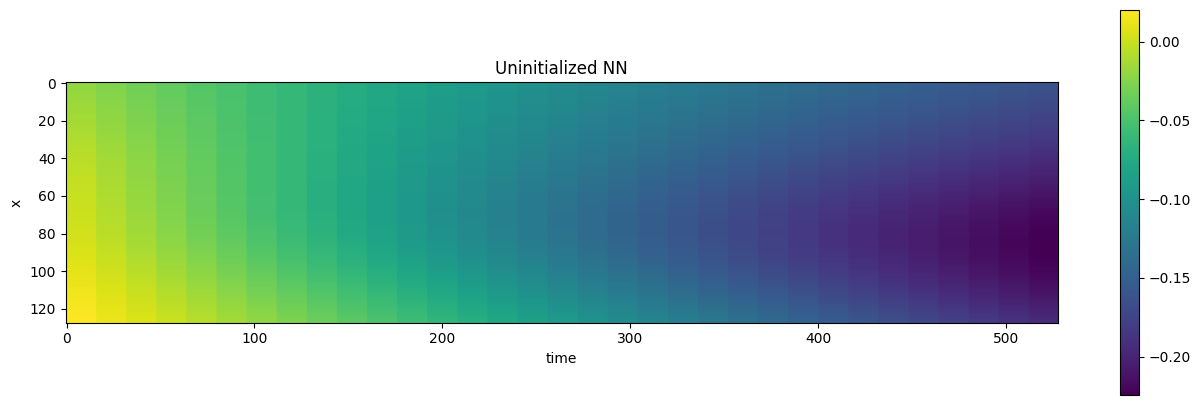

In [10]:
import pylab as plt
print("Size of grid_u: "+format(grid_u.shape))

session = Session(None)
session.initialize_variables()

def show_state(a, title):
    for i in range(4): a = np.concatenate( [a,a] , axis=3)
    a = np.reshape( a, [a.shape[1],a.shape[2]*a.shape[3]] )
    fig, axes = plt.subplots(1, 1, figsize=(16, 5))
    im = axes.imshow(a, origin='upper', cmap='viridis')
    plt.colorbar(im) ; plt.xlabel('time'); plt.ylabel('x'); plt.title(title)
    
print("Randomly initialized network state:")
show_state(session.run(grid_u),"Uninitialized NN")

In [11]:
# Boundary loss
N_SAMPLE_POINTS_BND = 100
x_bc, t_bc, u_bc = [math.concat([v_t0, v_x], axis=0) for v_t0, v_x in zip(boundary_tx(N_SAMPLE_POINTS_BND), open_boundary(N_SAMPLE_POINTS_BND))]
x_bc, t_bc, u_bc = np.asarray(x_bc,dtype=np.float32), np.asarray(t_bc,dtype=np.float32) ,np.asarray(u_bc,dtype=np.float32)
#with app.model_scope():
loss_u = math.l2_loss(network(x_bc, t_bc)[:, 0] - u_bc)  # normalizes by first dimension, N_bc

# Physics loss inside of domain
N_SAMPLE_POINTS_INNER = 10000
x_ph, t_ph = tf.convert_to_tensor(rnd.random_uniform([N_SAMPLE_POINTS_INNER], -1, 1)), tf.convert_to_tensor(rnd.random_uniform([N_SAMPLE_POINTS_INNER], 0, 1))
loss_ph = math.l2_loss(f(network(x_ph, t_ph)[:, 0], x_ph, t_ph))  # normalizes by first dimension, N_ph

# Combine
ph_factor = 1.
loss = loss_u + ph_factor * loss_ph # allows us to control the relative influence of loss_ph 

optim = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)
#optim = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss) # alternative, but not much benefit here

<ipython-input-5-f2ebc84042fb>:7: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  y = tf.layers.dense(y, 20, activation=tf.math.tanh, name='layer%d' % i, reuse=tf.AUTO_REUSE)
<ipython-input-5-f2ebc84042fb>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(y, 1, activation=None, name='layer_out', reuse=tf.AUTO_REUSE)


In [12]:
session.initialize_variables()

import time
start = time.time()

ITERS = 10000
for optim_step in range(ITERS+1):
  _, loss_value = session.run([optim, loss])
  if optim_step<3 or optim_step%10000==0: 
        print('Step %d, loss: %f' % (optim_step,loss_value))
        #show_state(grid_u)
        
end = time.time()
print("Runtime {:.2f}s".format(end-start))

Step 0, loss: 0.128657
Step 1, loss: 0.121498
Step 2, loss: 0.115962
Step 10000, loss: 0.043651
Runtime 950.78s


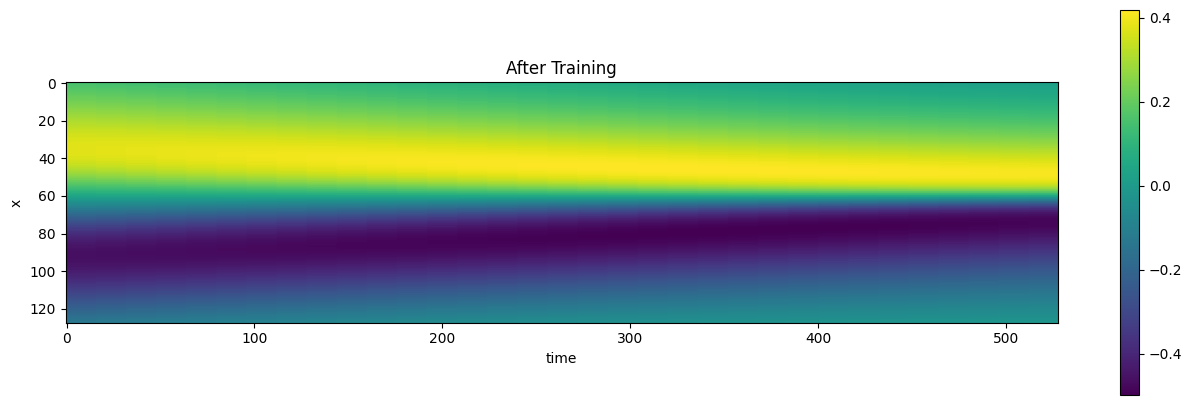

In [14]:
show_state(session.run(grid_u),"After Training")

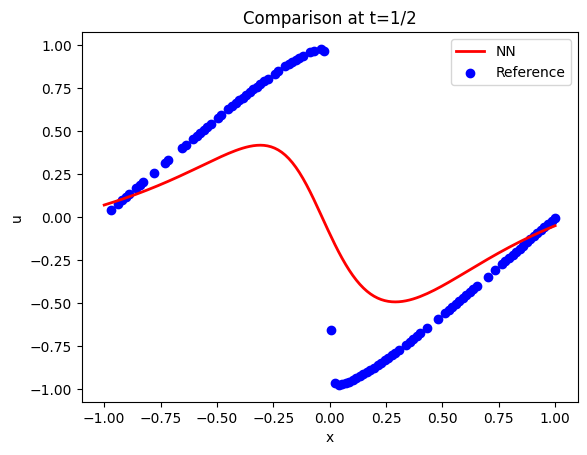

In [16]:
u = session.run(grid_u)

# solution is imposed at t=1/2 , which is 16 in the array
BC_TX = 16 
uT = u[0,:,BC_TX,0]

fig = plt.figure().gca()
fig.plot(np.linspace(-1,1,len(uT)), uT, lw=2, color='red', label="NN")
fig.scatter(x_bc[0:100], u_bc[0:100], color='blue', label="Reference")
plt.title("Comparison at t=1/2")
plt.xlabel('x'); plt.ylabel('u'); plt.legend()

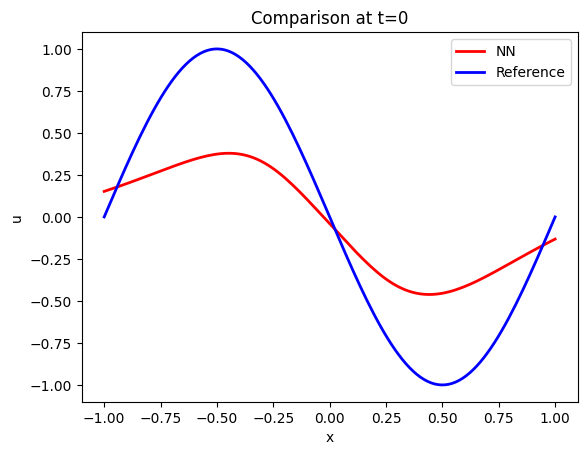

In [17]:
# ground truth solution at t0
t0gt = np.asarray( [ [-math.sin(np.pi * x) * 1.] for x in np.linspace(-1,1,N)] )
velP0 = u[0,:,0,0]

fig = plt.figure().gca()
fig.plot(np.linspace(-1,1,len(velP0)), velP0, lw=2, color='red', label="NN")
fig.plot(np.linspace(-1,1,len(t0gt)), t0gt, lw=2, color='blue', label="Reference") 
plt.title("Comparison at t=0")
plt.xlabel('x'); plt.ylabel('u'); plt.legend()

In [18]:
# modified code for the given question

In [19]:
!pip install --quiet phiflow==1.5.1
import math
from phi.tf.flow import *
import numpy as np
rnd = math.choose_backend(1)  

In [20]:
import collections
collections.Iterable = collections.abc.Iterable

In [21]:
def network(x, t):
    """ Dense neural network with 8 hidden layers and 3021 parameters in total.
        Parameters will only be allocated once (auto reuse).
    """
    y = math.stack([x, t], axis=-1)
    for i in range(8):
        y = tf.layers.dense(y, 20, activation=tf.math.tanh, name='layer%d' % i, reuse=tf.AUTO_REUSE)
    return tf.layers.dense(y, 1, activation=None, name='layer_out', reuse=tf.AUTO_REUSE)

def boundary_tx(N):
    x = np.linspace(-1,1,128)
    # precomputed solution from forward simulation:
    u = np.asarray( [0.008612174447657694, 0.02584669669548606, 0.043136357266407785, 0.060491074685516746, 0.07793926183951633, 0.0954779141740818, 0.11311894389663882, 0.1308497114054023, 0.14867023658641343, 0.1665634396808965, 0.18452263429574314, 0.20253084411376132, 0.22057828799835133, 0.23865132431365316, 0.25673879161339097, 0.27483167307082423, 0.2929182325574904, 0.3109944766354339, 0.3290477753208284, 0.34707880794585116, 0.36507311960102307, 0.38303584302507954, 0.40094962955534186, 0.4188235294008765, 0.4366357052408043, 0.45439856841363885, 0.4720845505219581, 0.4897081943759776, 0.5072391070000235, 0.5247011051514834, 0.542067187709797, 0.5593576751669057, 0.5765465453632126, 0.5936507311857876, 0.6106452944663003, 0.6275435911624945, 0.6443221318186165, 0.6609900633731869, 0.67752574922899, 0.6939334022562877, 0.7101938106059631, 0.7263049537163667, 0.7422506131457406, 0.7580207366534812, 0.7736033721649875, 0.7889776974379873, 0.8041371279965555, 0.8190465276590387, 0.8337064887158392, 0.8480617965162781, 0.8621229412131242, 0.8758057344502199, 0.8891341984763013, 0.9019806505391214, 0.9143881632159129, 0.9261597966464793, 0.9373647624856912, 0.9476871303793314, 0.9572273019669029, 0.9654367940878237, 0.9724097482283165, 0.9767381835635638, 0.9669484658390122, 0.659083299684951, -0.659083180712816, -0.9669485121167052, -0.9767382069792288, -0.9724097635533602, -0.9654367970450167, -0.9572273263645859, -0.9476871280825523, -0.9373647681120841, -0.9261598056102645, -0.9143881718456056, -0.9019807055316369, -0.8891341634240081, -0.8758057205293912, -0.8621229450911845, -0.8480618138204272, -0.833706571569058, -0.8190466131476127, -0.8041372124868691, -0.7889777195422356, -0.7736033858767385, -0.758020740007683, -0.7422507481169578, -0.7263049162371344, -0.7101938950789042, -0.6939334061553678, -0.677525822052029, -0.6609901538934517, -0.6443222327338847, -0.6275436932970322, -0.6106454472814152, -0.5936507836778451, -0.5765466491708988, -0.5593578078967361, -0.5420672759411125, -0.5247011730988912, -0.5072391580614087, -0.4897082914472909, -0.47208460952428394, -0.4543985995006753, -0.4366355580500639, -0.41882350871539187, -0.40094955631843376, -0.38303594105786365, -0.36507302109186685, -0.3470786936847069, -0.3290476440540586, -0.31099441589505206, -0.2929180880304103, -0.27483158663081614, -0.2567388003912687, -0.2386513127155433, -0.22057831776499126, -0.20253089403524566, -0.18452269630486776, -0.1665634500729787, -0.14867027528284874, -0.13084990929476334, -0.1131191325854089, -0.09547794429803691, -0.07793928430794522, -0.06049114408297565, -0.0431364527809777, -0.025846763281087953, -0.00861212501518312] );
    t = np.asarray(rnd.ones_like(x)) * 0.5
    perm = np.random.permutation(128) 
    return (x[perm])[0:N], (t[perm])[0:N], (u[perm])[0:N]

def _ALT_t0(N): # alternative, impose original initial state at t=0
    x = rnd.random_uniform([N], -1, 1)
    t = rnd.zeros_like(x)
    u = - math.sin(np.pi * x)
    return x, t, u

def open_boundary(N):
    t = rnd.random_uniform([N], 0, 1)
    x = math.concat([math.zeros([N//2]) + 1, math.zeros([N//2]) - 1], axis=0)
    u = math.zeros([N])
    return x, t, u

In [22]:
def f(u, x, t):
    """ Physics-based loss function with Burgers equation """
    u_t = gradients(u, t)
    u_x = gradients(u, x)
    # u_xx = gradients(u_x, x)
    return u_t + u_x

In [23]:
N=128
grids_xt = np.meshgrid(np.linspace(-1, 1, N), np.linspace(0, 1, 33), indexing='ij')
grid_x, grid_t = [tf.convert_to_tensor(t, tf.float32) for t in grids_xt]

# create 4D tensor with batch and channel dimensions in addition to space and time
# in this case gives shape=(1, N, 33, 1)
grid_u = math.expand_dims(network(grid_x, grid_t))

<ipython-input-21-f2ebc84042fb>:7: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  y = tf.layers.dense(y, 20, activation=tf.math.tanh, name='layer%d' % i, reuse=tf.AUTO_REUSE)
<ipython-input-21-f2ebc84042fb>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(y, 1, activation=None, name='layer_out', reuse=tf.AUTO_REUSE)


Size of grid_u: (1, 128, 33, 1)
Randomly initialized network state:


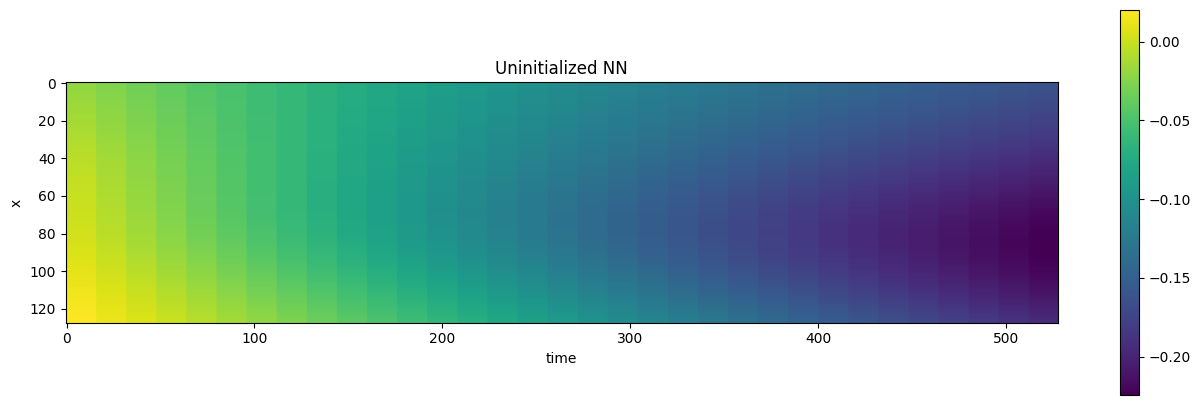

In [24]:
import pylab as plt
print("Size of grid_u: "+format(grid_u.shape))

session = Session(None)
session.initialize_variables()

def show_state(a, title):
    for i in range(4): a = np.concatenate( [a,a] , axis=3)
    a = np.reshape( a, [a.shape[1],a.shape[2]*a.shape[3]] )
    fig, axes = plt.subplots(1, 1, figsize=(16, 5))
    im = axes.imshow(a, origin='upper', cmap='viridis')
    plt.colorbar(im) ; plt.xlabel('time'); plt.ylabel('x'); plt.title(title)
    
print("Randomly initialized network state:")
show_state(session.run(grid_u),"Uninitialized NN")

In [25]:
# Boundary loss
N_SAMPLE_POINTS_BND = 100
x_bc, t_bc, u_bc = [math.concat([v_t0, v_x], axis=0) for v_t0, v_x in zip(boundary_tx(N_SAMPLE_POINTS_BND), open_boundary(N_SAMPLE_POINTS_BND))]
x_bc, t_bc, u_bc = np.asarray(x_bc,dtype=np.float32), np.asarray(t_bc,dtype=np.float32) ,np.asarray(u_bc,dtype=np.float32)
#with app.model_scope():
loss_u = math.l2_loss(network(x_bc, t_bc)[:, 0] - u_bc)  # normalizes by first dimension, N_bc

# Physics loss inside of domain
N_SAMPLE_POINTS_INNER = 10000
x_ph, t_ph = tf.convert_to_tensor(rnd.random_uniform([N_SAMPLE_POINTS_INNER], -1, 1)), tf.convert_to_tensor(rnd.random_uniform([N_SAMPLE_POINTS_INNER], 0, 1))
loss_ph = math.l2_loss(f(network(x_ph, t_ph)[:, 0], x_ph, t_ph))  # normalizes by first dimension, N_ph

# Combine
ph_factor = 1.
loss = loss_u + ph_factor * loss_ph # allows us to control the relative influence of loss_ph 

optim = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)
#optim = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss) # alternative, but not much benefit here

<ipython-input-21-f2ebc84042fb>:7: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  y = tf.layers.dense(y, 20, activation=tf.math.tanh, name='layer%d' % i, reuse=tf.AUTO_REUSE)
<ipython-input-21-f2ebc84042fb>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(y, 1, activation=None, name='layer_out', reuse=tf.AUTO_REUSE)


In [26]:
session.initialize_variables()

import time
start = time.time()

ITERS = 10000
for optim_step in range(ITERS+1):
  _, loss_value = session.run([optim, loss])
  if optim_step<3 or optim_step%1000==0: 
        print('Step %d, loss: %f' % (optim_step,loss_value))
        #show_state(grid_u)
        
end = time.time()
print("Runtime {:.2f}s".format(end-start))

Step 0, loss: 0.122322
Step 1, loss: 0.118510
Step 2, loss: 0.115319
Step 1000, loss: 0.080867
Step 2000, loss: 0.060675
Step 3000, loss: 0.023893
Step 4000, loss: 0.014264
Step 5000, loss: 0.012881
Step 6000, loss: 0.012401
Step 7000, loss: 0.012076
Step 8000, loss: 0.011808
Step 9000, loss: 0.011575
Step 10000, loss: 0.011369
Runtime 451.72s


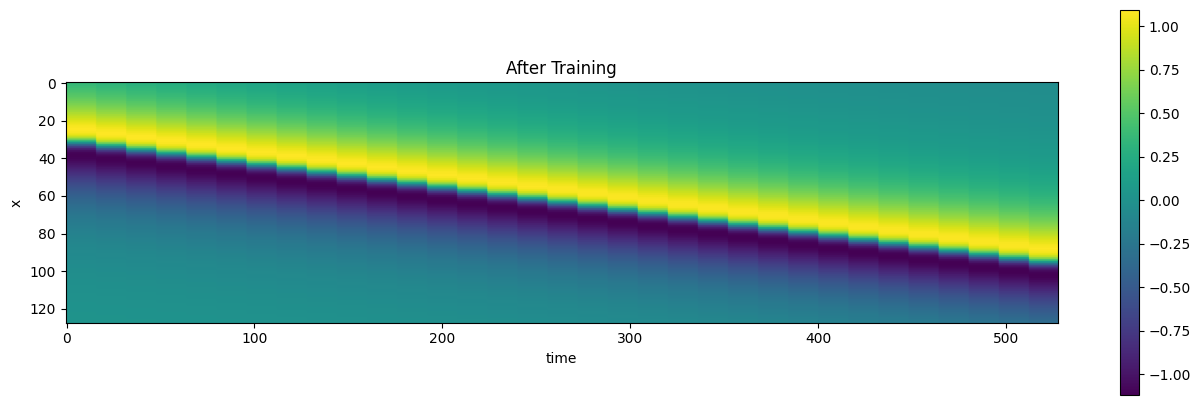

In [27]:
show_state(session.run(grid_u),"After Training")

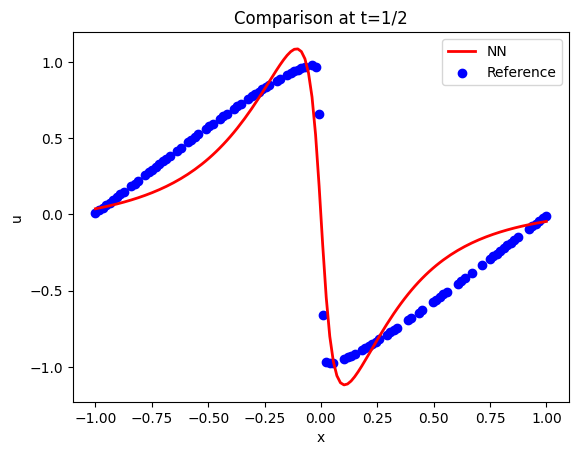

In [28]:
u = session.run(grid_u)

# solution is imposed at t=1/2 , which is 16 in the array
BC_TX = 16 
uT = u[0,:,BC_TX,0]

fig = plt.figure().gca()
fig.plot(np.linspace(-1,1,len(uT)), uT, lw=2, color='red', label="NN")
fig.scatter(x_bc[0:100], u_bc[0:100], color='blue', label="Reference")
plt.title("Comparison at t=1/2")
plt.xlabel('x'); plt.ylabel('u'); plt.legend()

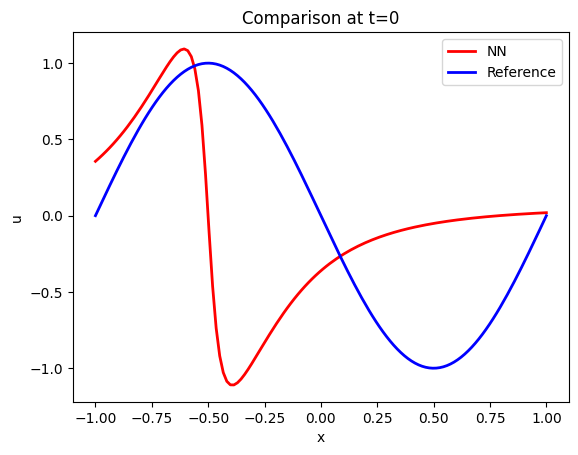

In [29]:
# ground truth solution at t0
t0gt = np.asarray( [ [-math.sin(np.pi * x) * 1.] for x in np.linspace(-1,1,N)] )
velP0 = u[0,:,0,0]

fig = plt.figure().gca()
fig.plot(np.linspace(-1,1,len(velP0)), velP0, lw=2, color='red', label="NN")
fig.plot(np.linspace(-1,1,len(t0gt)), t0gt, lw=2, color='blue', label="Reference") 
plt.title("Comparison at t=0")
plt.xlabel('x'); plt.ylabel('u'); plt.legend()